In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy

import tensorflow as tf

In [3]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ruta al archivo CSV
#file_path = '/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/historico_completo.csv'
file_path = '/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/datos_2024/ocupacion_2024.csv'
# Leer el archivo CSV
ocupacion_historica = pd.read_csv(file_path)

# Mostrar los primeros registros
ocupacion_historica.head()

,id,cod_empresa,linea_codigo,sevar_codigo,dia,franja_horaria,ascensos_promedio,ocupacion_promedio,ocupacion_maxima_promedio,ocupacion_maxima,cantidad,tipo_dia
0,20240101,50,76,3267,2024-01-01,84,5.0,0.916667,4.0,4,1,FERIADO NO LABORABLE
1,20240101,50,78,4016,2024-01-01,88,5.0,1.709091,5.0,5,1,FERIADO NO LABORABLE
2,20240101,50,45,3983,2024-01-01,89,3.0,0.690476,3.0,3,1,FERIADO NO LABORABLE
3,20240101,50,45,3973,2024-01-01,90,3.0,0.482759,2.0,2,1,FERIADO NO LABORABLE
4,20240101,50,40,7883,2024-01-01,90,1.0,0.272727,1.0,1,1,FERIADO NO LABORABLE


In [5]:
#precipitaciones = pd.read_csv('/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/pluviometros.csv')
precipitaciones = pd.read_csv('/content/drive/MyDrive/Trabajo_final-Master_en_Big_Data/Datos/datos_2024/acc_2024_2.csv',
                              encoding='latin-1')
precipitaciones.head()

,nombre,fecha,instant_precipitation,ac_15,ac_1440
0,Capurro,2024-01-01T00:00:00.000-03,0.0,0.0,0.0
1,Capurro,2024-01-01T00:05:00.000-03,0.0,0.0,0.0
2,Capurro,2024-01-01T00:10:00.000-03,0.0,0.0,0.0
3,Capurro,2024-01-01T00:15:00.000-03,0.0,0.0,0.0
4,Capurro,2024-01-01T00:20:00.000-03,0.0,0.0,0.0


In [6]:
precipitaciones['fecha'] = pd.to_datetime(precipitaciones['fecha'])
precipitaciones['fecha'] = precipitaciones['fecha'].dt.date
precipitaciones.head()

,nombre,fecha,instant_precipitation,ac_15,ac_1440
0,Capurro,2024-01-01,0.0,0.0,0.0
1,Capurro,2024-01-01,0.0,0.0,0.0
2,Capurro,2024-01-01,0.0,0.0,0.0
3,Capurro,2024-01-01,0.0,0.0,0.0
4,Capurro,2024-01-01,0.0,0.0,0.0


In [83]:
#se agrupa por fecha con los promedios en cada columna, con el enfoque de no considerar cada estacion por separado
columnas_lluvia = ['instant_precipitation', 'ac_15', 'ac_1440']

promedio_precipitaciones = precipitaciones.groupby('fecha')[columnas_lluvia].mean().reset_index()


In [8]:
# Renombrar columnas para mayor claridad
promedio_precipitaciones.rename(columns={
    'instant_precipitation': 'instant_precipitation_avg',
    'ac_15': 'ac_15_avg',
    'ac_1440': 'ac_1440_avg',
}, inplace=True)

In [9]:
promedio_precipitaciones.head()

,fecha,instant_precipitation_avg,ac_15_avg,ac_1440_avg
0,2024-01-01,0.000000,0.000000,0.000000
1,2024-01-02,0.000462,0.001386,0.061442
2,2024-01-03,0.000000,0.000000,0.071605
3,2024-01-04,0.000000,0.000000,0.000000
4,2024-01-05,0.000293,0.000878,0.022829


In [10]:
ocupacion_historica['fecha'] = pd.to_datetime(ocupacion_historica['dia'])
ocupacion_historica['fecha'] = ocupacion_historica['fecha'].dt.date

In [11]:
ocupacion_historica.head()

,id,cod_empresa,linea_codigo,sevar_codigo,dia,franja_horaria,ascensos_promedio,ocupacion_promedio,ocupacion_maxima_promedio,ocupacion_maxima,cantidad,tipo_dia,fecha
0,20240101,50,76,3267,2024-01-01,84,5.0,0.916667,4.0,4,1,FERIADO NO LABORABLE,2024-01-01
1,20240101,50,78,4016,2024-01-01,88,5.0,1.709091,5.0,5,1,FERIADO NO LABORABLE,2024-01-01
2,20240101,50,45,3983,2024-01-01,89,3.0,0.690476,3.0,3,1,FERIADO NO LABORABLE,2024-01-01
3,20240101,50,45,3973,2024-01-01,90,3.0,0.482759,2.0,2,1,FERIADO NO LABORABLE,2024-01-01
4,20240101,50,40,7883,2024-01-01,90,1.0,0.272727,1.0,1,1,FERIADO NO LABORABLE,2024-01-01


In [12]:
print(ocupacion_historica.tipo_dia.unique().tolist())

['FERIADO NO LABORABLE', 'HABIL', 'FERIADO LABORABLE', 'TIPO DOMINGO', 'TIPO SABADO', 'DIA DE LOS MUNICIPIOS DE AMERICA']


In [13]:
#Cantidad de valores de ocupacion_promedio menores a 0
cantidad = (ocupacion_historica['ocupacion_promedio'] < 0).sum()
print(cantidad)

25102


In [14]:
len(ocupacion_historica)

3979672

In [15]:
#Convierto todos los valores de ocupacion_promedio menores a 0 en 0 para corregir los datos según lo explicado por los técnicos de IM
ocupacion_historica.loc[ocupacion_historica['ocupacion_promedio'] < 0, 'ocupacion_promedio'] = 0

In [16]:
#Cantidad de valores de ocupacion_promedio menores a 0
cantidad1 = (ocupacion_historica['ocupacion_promedio'] < 0).sum()
print(cantidad1)

0


In [17]:
ocupacion_historica.loc[ocupacion_historica['tipo_dia'] == 'DIA DE LOS MUNICIPIOS DE AMERICA', 'tipo_dia'] = 'HABIL'

In [18]:
print(ocupacion_historica.tipo_dia.unique().tolist())

['FERIADO NO LABORABLE', 'HABIL', 'FERIADO LABORABLE', 'TIPO DOMINGO', 'TIPO SABADO']


In [19]:
columnas_ocupacion = ['ascensos_promedio', 'ocupacion_promedio', 'ocupacion_maxima_promedio', 'ocupacion_maxima']
#se hacen los promedios de las columnas agrupando por dia, tipo de dia y linea de ómnibus
prom_ocupaciones = ocupacion_historica.groupby(['fecha', 'tipo_dia', 'linea_codigo'])[columnas_ocupacion].mean().reset_index()

In [20]:
# Renombrar columnas para mayor claridad
prom_ocupaciones.rename(columns={
    'ascensos_promedio': 'acensos_avg',
    'ocupacion_promedio': 'ocupacion_avg',
    'ocupacion_maxima_promedio': 'ocupacion_max_avg_avg',
    'ocupacion_maxima': 'ocupacion_max_avg'
}, inplace=True)

In [21]:
# Se unen los nuevos datos agrupados de las precipitaciones y de la ocupación
datos_combinados = pd.merge(
    prom_ocupaciones.sort_values('fecha'),
    promedio_precipitaciones.sort_values('fecha'),
    on='fecha'
)

In [22]:
datos_combinados.head()

,fecha,tipo_dia,linea_codigo,acensos_avg,ocupacion_avg,ocupacion_max_avg_avg,ocupacion_max_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg
0,2024-01-01,FERIADO NO LABORABLE,3,2.0,0.418919,1.0,1.0,0.0,0.0,0.0
1,2024-01-01,FERIADO NO LABORABLE,485,12.0,4.021277,10.0,10.0,0.0,0.0,0.0
2,2024-01-01,FERIADO NO LABORABLE,480,4.0,1.373494,4.0,4.0,0.0,0.0,0.0
3,2024-01-01,FERIADO NO LABORABLE,447,3.0,0.697368,3.0,3.0,0.0,0.0,0.0
4,2024-01-01,FERIADO NO LABORABLE,446,29.0,6.714286,27.0,27.0,0.0,0.0,0.0


In [23]:
len(datos_combinados)

47593

In [24]:
# Se filtra una línea específica
linea_especifica = 447
datos_filtrados = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica]

# Definir las columnas necesarias
datos_filtrados = datos_filtrados[['fecha', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg',  'ac_15_avg', 'ac_1440_avg']]
datos_filtrados.set_index('fecha', inplace=True)

In [25]:
datos_filtrados.head()

,tipo_dia,ocupacion_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg
fecha,,,,,
2024-01-01,FERIADO NO LABORABLE,0.697368,0.000000,0.000000,0.000000
2024-01-02,HABIL,16.317506,0.000462,0.001386,0.061442
2024-01-03,HABIL,18.163716,0.000000,0.000000,0.071605
2024-01-04,HABIL,18.599695,0.000000,0.000000,0.000000
2024-01-05,HABIL,18.172107,0.000293,0.000878,0.022829


In [26]:
# Test de Dickey-Fuller aumentado
resultado_adf = adfuller(datos_filtrados['ocupacion_avg'])
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"p-valor: {resultado_adf[1]}")

#los valores que nos da, indicarian que la serie es estacionaria

Estadístico ADF: -4.017706493188112
p-valor: 0.001320580690783796


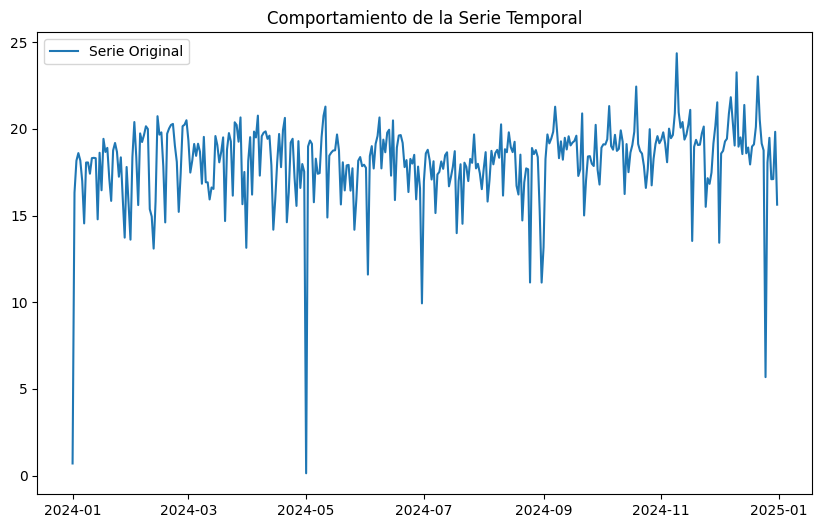

In [27]:
# Gráfico de la serie original
plt.figure(figsize=(10, 6))
plt.plot(datos_filtrados['ocupacion_avg'], label='Serie Original')
plt.title('Comportamiento de la Serie Temporal')
plt.legend()
plt.show()

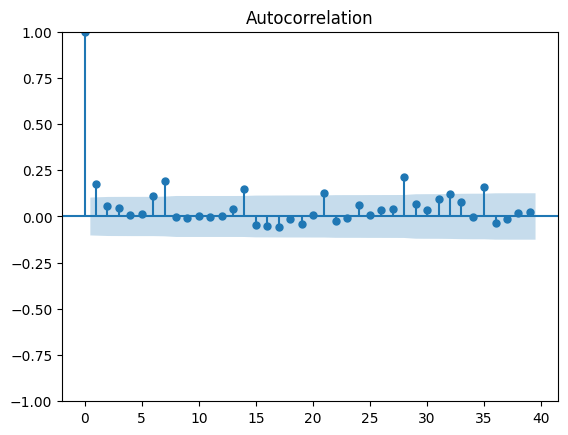

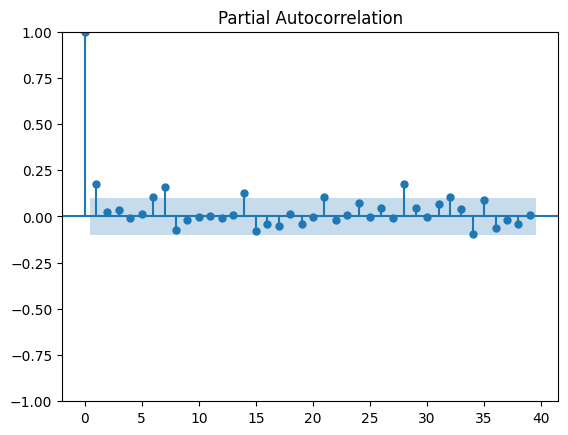

In [28]:
# Gráfico ACF y PACF para identificar estacionalidad o lags significativos
plot_acf(datos_filtrados['ocupacion_avg'], lags=39)
plot_pacf(datos_filtrados['ocupacion_avg'], lags=39)
plt.show()

In [29]:
# Codificación One-Hot
tipo_dia_dummies = pd.get_dummies(datos_filtrados['tipo_dia'], prefix='tipo_dia')
tipo_dia_dummies = tipo_dia_dummies.astype(int)
tipo_dia_dummies.head()

,tipo_dia_FERIADO LABORABLE,tipo_dia_FERIADO NO LABORABLE,tipo_dia_HABIL,tipo_dia_TIPO DOMINGO,tipo_dia_TIPO SABADO
fecha,,,,,
2024-01-01,0,1,0,0,0
2024-01-02,0,0,1,0,0
2024-01-03,0,0,1,0,0
2024-01-04,0,0,1,0,0
2024-01-05,0,0,1,0,0


In [30]:
# Se unen los datos_filtrados anteriormente con las nuevas columnas que surgieron del get_dummies (columnas one hot)
datos_filtrados = pd.concat([datos_filtrados, tipo_dia_dummies], axis=1).reset_index()

In [31]:
# Se renombran las columnas para eliminar espacios
datos_filtrados.rename(columns={
    'tipo_dia_FERIADO NO LABORABLE': 'tipo_dia_feriado_no_laborable',
    'tipo_dia_FERIADO LABORABLE': 'tipo_dia_feriado_laborable',
    'tipo_dia_TIPO DOMINGO': 'tipo_dia_domingo',
    'tipo_dia_TIPO SABADO': 'tipo_dia_sabado'
}, inplace=True)

In [32]:
datos_filtrados.head()

,fecha,tipo_dia,ocupacion_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg,tipo_dia_feriado_laborable,tipo_dia_feriado_no_laborable,tipo_dia_HABIL,tipo_dia_domingo,tipo_dia_sabado
0,2024-01-01,FERIADO NO LABORABLE,0.697368,0.000000,0.000000,0.000000,0,1,0,0,0
1,2024-01-02,HABIL,16.317506,0.000462,0.001386,0.061442,0,0,1,0,0
2,2024-01-03,HABIL,18.163716,0.000000,0.000000,0.071605,0,0,1,0,0
3,2024-01-04,HABIL,18.599695,0.000000,0.000000,0.000000,0,0,1,0,0
4,2024-01-05,HABIL,18.172107,0.000293,0.000878,0.022829,0,0,1,0,0


In [33]:
#se filtran las variables que finalmente van a ser exogenas en nuestro modelo
exogenas = datos_filtrados[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia_feriado_no_laborable', 'tipo_dia_feriado_laborable', 'tipo_dia_HABIL', 'tipo_dia_domingo', 'tipo_dia_sabado']]

In [34]:
# Definir el porcentaje de datos de entrenamiento
train_size = int(len(datos_filtrados) * 0.8)  # 80% para entrenamiento

# Separar los datos
train_y, test_y = datos_filtrados['ocupacion_avg'][:train_size], datos_filtrados['ocupacion_avg'][train_size:]
train_exog, test_exog = exogenas[:train_size], exogenas[train_size:]

# Verificar tamaños
print(f"Tamaño Train: {len(train_y)}, Tamaño Test: {len(test_y)}")

Tamaño Train: 292, Tamaño Test: 73


In [35]:
train_y.head()

,ocupacion_avg
0,0.697368
1,16.317506
2,18.163716
3,18.599695
4,18.172107


In [36]:
# Definir variable objetivo
y = train_y.dropna()

# Ajustar el modelo ARIMAX
modelo = SARIMAX(y, exog=train_exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 24))
resultado = modelo.fit()

# Resumen del modelo
print(resultado.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                      ocupacion_avg   No. Observations:                  292
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                -521.181
Date:                            Mon, 21 Apr 2025   AIC                           1068.362
Time:                                    21:22:29   BIC                           1116.160
Sample:                                         0   HQIC                          1087.508
                                            - 292                                         
Covariance Type:                              opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
instant_precipitation_avg      -654.8074   1165.021     -0.562      0.574   

In [37]:
# Predicción en base a datos históricos
prediccion = resultado.get_prediction(start=-24, dynamic=False)
prediccion_intervalo = prediccion.conf_int()

# Predicción para nuevos pasos
forecast = resultado.get_forecast(steps=len(test_y), exog=test_exog)
forecast_df = forecast.summary_frame()

print(forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])

ocupacion_avg       mean  mean_ci_lower  mean_ci_upper
292            17.069663      14.244062      19.895265
293            19.331388      16.389389      22.273387
294            19.135458      16.157883      22.113034
295            18.155606      15.166957      21.144255
296            17.138774      14.146660      20.130888
..                   ...            ...            ...
360            18.730816      15.735092      21.726539
361            18.916481      15.920757      21.912204
362            15.976556      12.980833      18.972279
363            18.736421      15.740698      21.732145
364            18.735980      15.740257      21.731704

[73 rows x 3 columns]


In [38]:
# Valores reales y predichos
valores_reales = y[-24:]
valores_predichos = prediccion.predicted_mean

# Cálculo de métricas
mae = mean_absolute_error(valores_reales, valores_predichos)
rmse = np.sqrt(mean_squared_error(valores_reales, valores_predichos))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.9811781274913526
RMSE: 1.2470628938770365


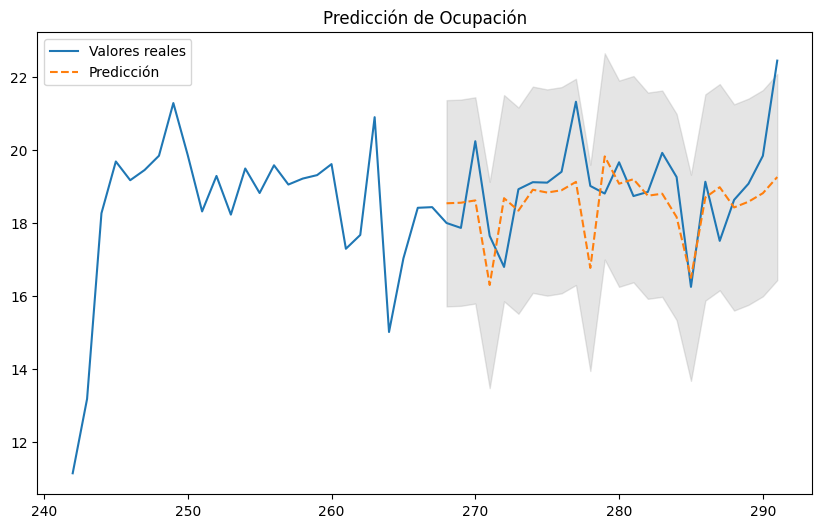

In [39]:
# Gráfico de valores reales vs predichos
plt.figure(figsize=(10, 6))
plt.plot(y[-50:], label='Valores reales')
plt.plot(prediccion.predicted_mean[-50:], label='Predicción', linestyle='--')
plt.fill_between(prediccion_intervalo.index[-50:],
                 prediccion_intervalo.iloc[-50:, 0],
                 prediccion_intervalo.iloc[-50:, 1], color='gray', alpha=0.2)
plt.legend()
plt.title("Predicción de Ocupación")
plt.show()

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suponiendo que df_wide es tu dataset completo
# y que ya contiene la columna 'ocupacion_avg' y las variables exógenas:

exog_vars = ['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg',
             'tipo_dia_feriado_no_laborable', 'tipo_dia_feriado_laborable',
             'tipo_dia_HABIL', 'tipo_dia_domingo', 'tipo_dia_sabado']

modelo = SARIMAX(y,
                 exog=train_exog,
                 order=(1, 0, 1),
                 seasonal_order=(1, 0, 1, 24))

results = modelo.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
print(datos_filtrados[['instant_precipitation_avg', 'ac_15_avg']].describe())

       instant_precipitation_avg   ac_15_avg
count                 365.000000  365.000000
mean                    0.006586    0.019759
std                     0.019262    0.057797
min                     0.000000    0.000000
25%                     0.000000    0.000000
50%                     0.000042    0.000126
75%                     0.002083    0.006447
max                     0.172978    0.518934


In [43]:
datos_filtrados.head()

,fecha,tipo_dia,ocupacion_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg,tipo_dia_feriado_laborable,tipo_dia_feriado_no_laborable,tipo_dia_HABIL,tipo_dia_domingo,tipo_dia_sabado
0,2024-01-01,FERIADO NO LABORABLE,0.697368,0.000000,0.000000,0.000000,0,1,0,0,0
1,2024-01-02,HABIL,16.317506,0.000462,0.001386,0.061442,0,0,1,0,0
2,2024-01-03,HABIL,18.163716,0.000000,0.000000,0.071605,0,0,1,0,0
3,2024-01-04,HABIL,18.599695,0.000000,0.000000,0.000000,0,0,1,0,0
4,2024-01-05,HABIL,18.172107,0.000293,0.000878,0.022829,0,0,1,0,0


#Implementación de MLP

In [44]:
#Parametros
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split=0.2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 344.2350 - mae: 18.4411 - val_loss: 329.6323 - val_mae: 17.9800
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 324.1935 - mae: 17.8408 - val_loss: 319.9057 - val_mae: 17.6956
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 320.9385 - mae: 17.7328 - val_loss: 308.2944 - val_mae: 17.3489
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 308.0072 - mae: 17.3694 - val_loss: 293.2003 - val_mae: 16.8864
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 289.6204 - mae: 16.8383 - val_loss: 272.5316 - val_mae: 16.2243
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 267.3726 - mae: 16.1231 - val_loss: 245.5471 - val_mae: 15.3211
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 238.7841 - mae: 15.1190 - val_loss: 212.8387 - val_mae: 14.2007
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 219.3040 - mae: 14.4915 - val_loss: 174.5505 - val_mae: 12.7307
Epoch 9/150
8/8 ━━━━━━━━

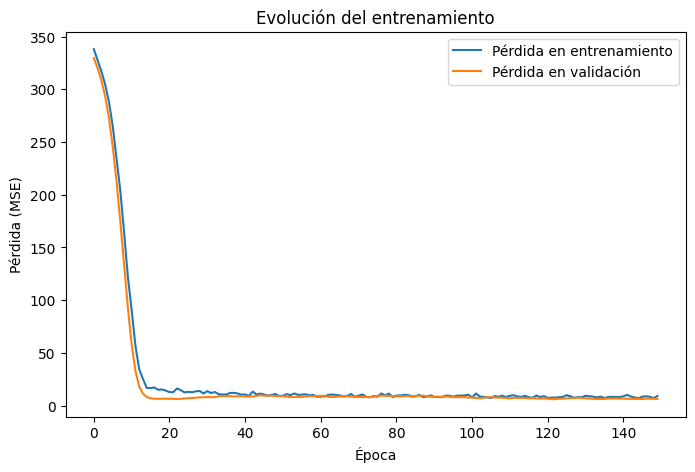

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Reiniciar el índice para tener la columna 'fecha' como variable normal
df = datos_filtrados.reset_index()

# Seleccionar variables predictoras y variable objetivo
# Objetivo: predecir 'ocupacion_avg'
# Características: variables numéricas de precipitaciones y la variable categórica 'tipo_dia'

X = df[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df['ocupacion_avg']
fechas = df['fecha']  # Guardamos la fecha para poder graficar posteriormente

# Codificar la variable categórica 'tipo_dia' utilizando OneHotEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tipo_dia'])
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y test, incluyendo la variable 'fecha'
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y, fechas, test_size=0.2, random_state=42
)

# Normalización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo MLP usando una capa de entrada explícita
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Mostrar el resumen del modelo
model.summary()

history = model.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo en el conjunto de test
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


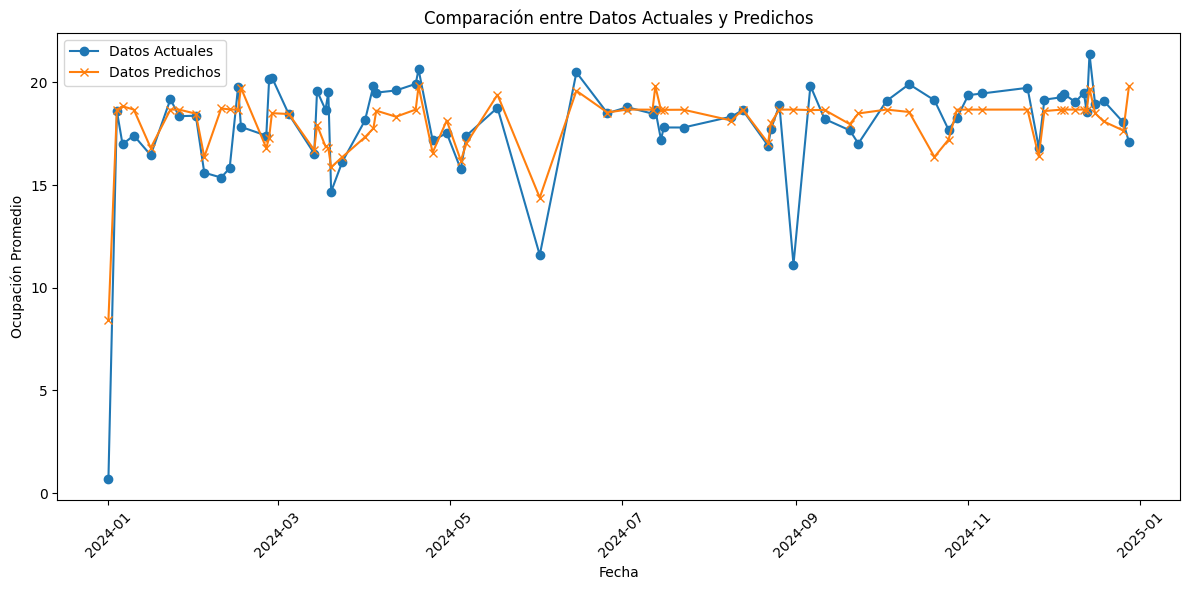

In [46]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': fecha_test,
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Estudio con parametros
Se probo con varios paramentros mirando el documento y los diferentes parametros que uso tanto para el modelo de los finde semana como los día de semana, en nuestro caso no lo dividimos en esta ocación y se uso el mismo modelo para todos los días de la semana.

- Con learning_rate = 0.1, _learning_rate = 0.01 y con _learning_rate = 0.001, este último fue el que mejores resultados de aprendizaje resulto.

- Con epochs probamos 100, 20 y 150. Mirando la gráfica del entrenamiento y la de la comparación de los datos quedamos con 150 epochs

- La función de activación probamos con tahn y relu dado que en el documento usaba esas dos. Para la realidad de nuestros datos la que mejor resulta es la relu,

##Pruebas del modelo MLP con 5 lineas distintas y todo juntas.

In [47]:
datos_combinados

,fecha,tipo_dia,linea_codigo,acensos_avg,ocupacion_avg,ocupacion_max_avg_avg,ocupacion_max_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg
0,2024-01-01,FERIADO NO LABORABLE,3,2.000000,0.418919,1.000000,1.000000,0.0,0.0,0.0
1,2024-01-01,FERIADO NO LABORABLE,485,12.000000,4.021277,10.000000,10.000000,0.0,0.0,0.0
2,2024-01-01,FERIADO NO LABORABLE,480,4.000000,1.373494,4.000000,4.000000,0.0,0.0,0.0
3,2024-01-01,FERIADO NO LABORABLE,447,3.000000,0.697368,3.000000,3.000000,0.0,0.0,0.0
4,2024-01-01,FERIADO NO LABORABLE,446,29.000000,6.714286,27.000000,27.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
47588,2024-12-31,HABIL,45,41.911290,12.318449,26.786290,26.927419,0.0,0.0,0.0
47589,2024-12-31,HABIL,43,40.438356,11.769227,21.835616,22.698630,0.0,0.0,0.0
47590,2024-12-31,HABIL,41,46.339506,16.846266,28.748457,31.416667,0.0,0.0,0.0
47591,2024-12-31,HABIL,71,27.714286,8.329954,17.738095,18.523810,0.0,0.0,0.0


In [48]:
datos_combinados.drop_duplicates(subset=['linea_codigo']).nlargest(5, 'ocupacion_max_avg')

,fecha,tipo_dia,linea_codigo,acensos_avg,ocupacion_avg,ocupacion_max_avg_avg,ocupacion_max_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg
118,2024-01-02,HABIL,10,82.838983,21.764297,42.567797,42.567797,0.000462,0.001386,0.061442
45,2024-01-02,HABIL,129,94.306061,20.556290,38.819697,40.227273,0.000462,0.001386,0.061442
134,2024-01-02,HABIL,88,67.611842,19.715300,36.992325,40.078947,0.000462,0.001386,0.061442
86,2024-01-02,HABIL,449,87.437500,20.506632,37.755682,38.397727,0.000462,0.001386,0.061442
109,2024-01-02,HABIL,20,66.989160,22.607393,36.207317,36.878049,0.000462,0.001386,0.061442


###Vamos a entrenar modelos para 4 líneas más, dos tomando las que tiene mayor ocupación, una tomando la que tiene menor ocupación y otra random. A estas 4 hay que sumarle la línea random con la cual comenzamos más arriba



####Linea 10

In [49]:
# Se filtra una línea específica
linea_especifica = 10
datos_filtrados_linea10 = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica]

# Definir las columnas necesarias
datos_filtrados_linea10 = datos_filtrados_linea10[['fecha', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg',  'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_linea10.set_index('fecha', inplace=True)

In [50]:
datos_filtrados_linea10.head()

,tipo_dia,ocupacion_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg
fecha,,,,,
2024-01-02,HABIL,21.764297,0.000462,0.001386,0.061442
2024-01-03,HABIL,23.316675,0.000000,0.000000,0.071605
2024-01-04,HABIL,23.533862,0.000000,0.000000,0.000000
2024-01-05,HABIL,22.768866,0.000293,0.000878,0.022829
2024-01-06,FERIADO LABORABLE,18.611187,0.005698,0.017094,0.875179


In [51]:
from statsmodels.tsa.stattools import adfuller

# Test de Dickey-Fuller aumentado
resultado_adf = adfuller(datos_filtrados_linea10['ocupacion_avg'])
print(f"Estadístico ADF: {resultado_adf[0]}")
print(f"p-valor: {resultado_adf[1]}")

#los valores que nos da, indicarian que la serie es estacionaria

Estadístico ADF: -3.9491440074462014
p-valor: 0.0017015140666038404


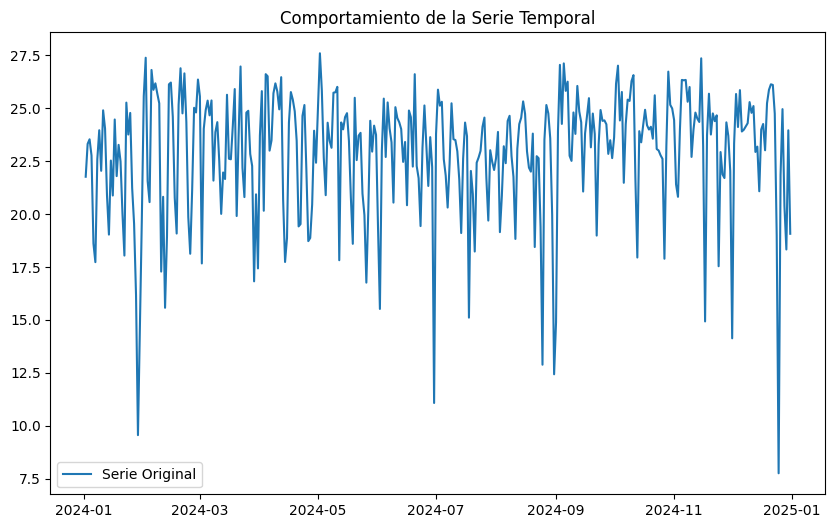

In [52]:
import matplotlib.pyplot as plt

# Gráfico de la serie original
plt.figure(figsize=(10, 6))
plt.plot(datos_filtrados_linea10['ocupacion_avg'], label='Serie Original')
plt.title('Comportamiento de la Serie Temporal')
plt.legend()
plt.show()

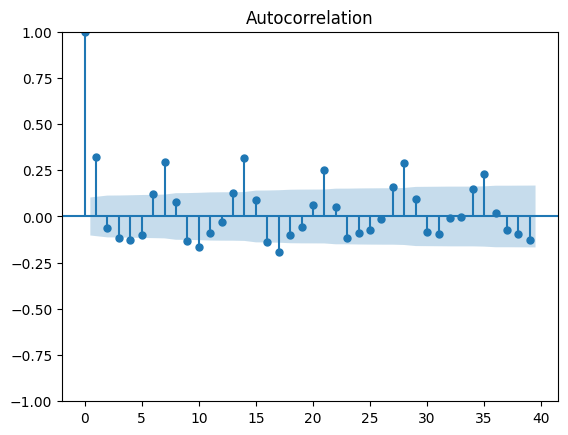

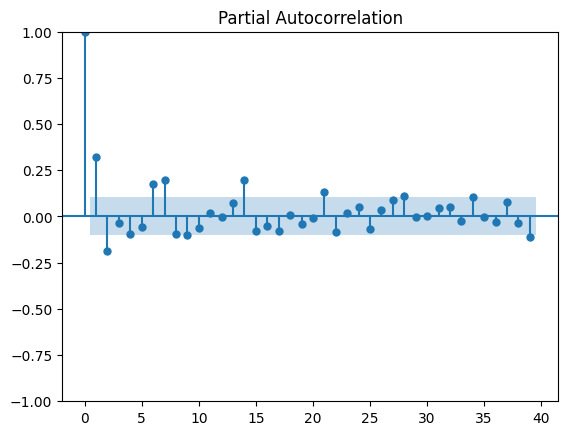

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico ACF y PACF para identificar estacionalidad o lags significativos
plot_acf(datos_filtrados_linea10['ocupacion_avg'], lags=39)
plot_pacf(datos_filtrados_linea10['ocupacion_avg'], lags=39)
plt.show()

In [54]:
#Parametros
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split=0.2

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 532.8248 - mae: 22.8784 - val_loss: 528.6353 - val_mae: 22.7519
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 532.4322 - mae: 22.9190 - val_loss: 520.1693 - val_mae: 22.5568
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 511.3945 - mae: 22.4281 - val_loss: 511.4787 - val_mae: 22.3546
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 499.7325 - mae: 22.1395 - val_loss: 499.7896 - val_mae: 22.0805
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 484.9683 - mae: 21.8050 - val_loss: 484.1510 - val_mae: 21.7043
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 470.0154 - mae: 21.4329 - val_loss: 461.9278 - val_mae: 21.1543
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 453.1995 - mae: 21.0473 - val_loss: 430.5680 - val_mae: 20.3578
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 413.9407 - mae: 20.0224 - val_loss: 387.5687 - val_mae: 19.2412
Epoch 9/150
8/8 ━━━━━━━━

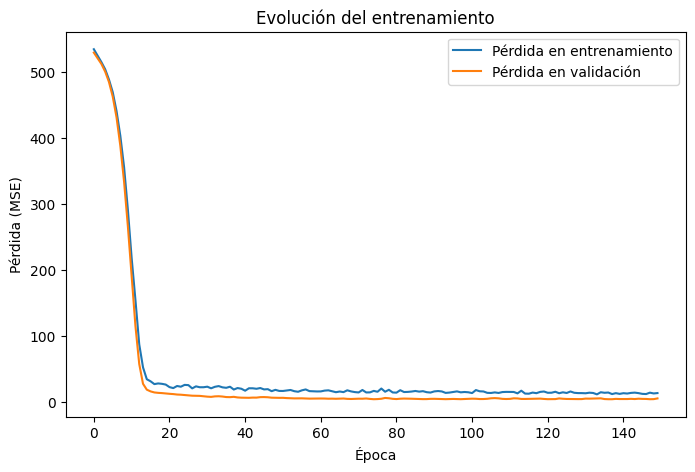

In [55]:
# Reiniciar el índice para tener la columna 'fecha' como variable normal
df_linea10 = datos_filtrados_linea10.reset_index()

# Seleccionar variables predictoras y variable objetivo
# Objetivo: predecir 'ocupacion_avg'
# Características: variables numéricas de precipitaciones y la variable categórica 'tipo_dia'

X = df_linea10[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df_linea10['ocupacion_avg']
fechas = df_linea10['fecha']  # Guardamos la fecha para poder graficar posteriormente

# Codificar la variable categórica 'tipo_dia' utilizando OneHotEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tipo_dia'])
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y test, incluyendo la variable 'fecha'
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y, fechas, test_size=0.2, random_state=42
)

# Normalización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo MLP usando una capa de entrada explícita
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Mostrar el resumen del modelo
model.summary()

history = model.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo en el conjunto de test
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


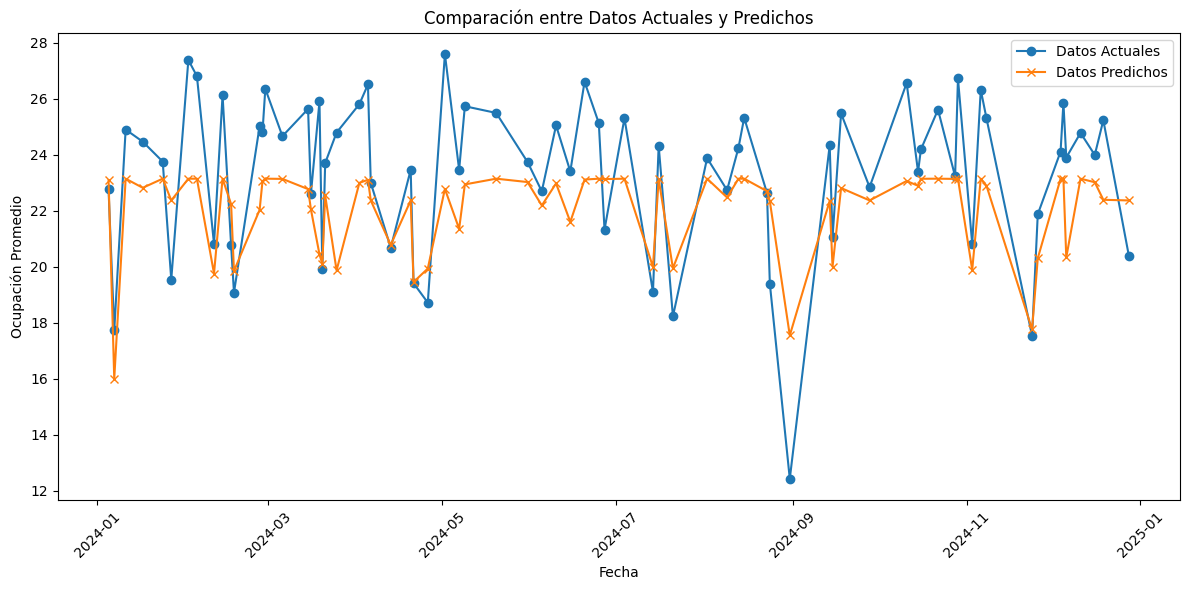

In [56]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': fecha_test,
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Linea 129

In [57]:
# Se filtra una línea específica
linea_especifica = 129
datos_filtrados_linea129 = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica]

In [58]:
# Definir las columnas necesarias
datos_filtrados_linea129 = datos_filtrados_linea129[['fecha', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg',  'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_linea129.set_index('fecha', inplace=True)

In [59]:
#Parametros
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split=0.2

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 524.2290 - mae: 22.7041 - val_loss: 510.8401 - val_mae: 22.3165
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 503.9877 - mae: 22.2240 - val_loss: 492.7036 - val_mae: 21.8707
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 476.8758 - mae: 21.5598 - val_loss: 472.5581 - val_mae: 21.3591
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 459.9522 - mae: 21.1369 - val_loss: 448.1507 - val_mae: 20.7372
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 428.7923 - mae: 20.3134 - val_loss: 418.0721 - val_mae: 20.0123
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 392.7260 - mae: 19.3129 - val_loss: 380.8848 - val_mae: 19.0620
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 356.2591 - mae: 18.3324 - val_loss: 335.4939 - val_mae: 17.8218
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 297.5025 - mae: 16.4827 - val_loss: 281.9818 - val_mae: 16.2060
Epoch 9/150
8/8 ━━━━━━━━

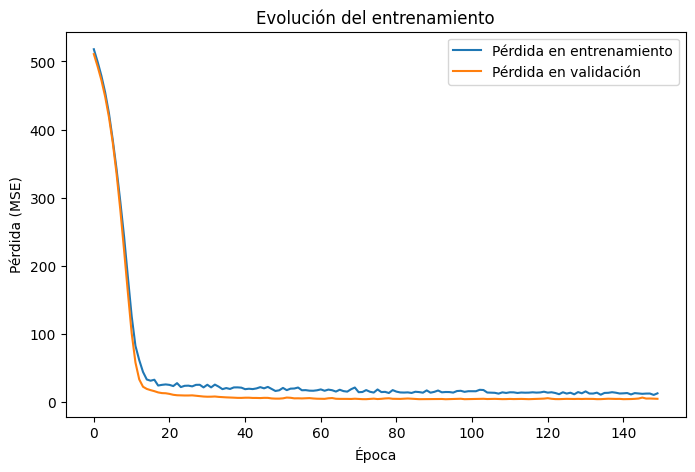

In [60]:
# Reiniciar el índice para tener la columna 'fecha' como variable normal
df_linea129 = datos_filtrados_linea10.reset_index()

# Seleccionar variables predictoras y variable objetivo
# Objetivo: predecir 'ocupacion_avg'
# Características: variables numéricas de precipitaciones y la variable categórica 'tipo_dia'

X = df_linea129[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df_linea129['ocupacion_avg']
fechas = df_linea129['fecha']  # Guardamos la fecha para poder graficar posteriormente

# Codificar la variable categórica 'tipo_dia' utilizando OneHotEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tipo_dia'])
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y test, incluyendo la variable 'fecha'
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y, fechas, test_size=0.2, random_state=42
)

# Normalización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo MLP usando una capa de entrada explícita
model_129 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model_129.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Mostrar el resumen del modelo
model_129.summary()

history = model_129.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo en el conjunto de test
loss, mae = model_129.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


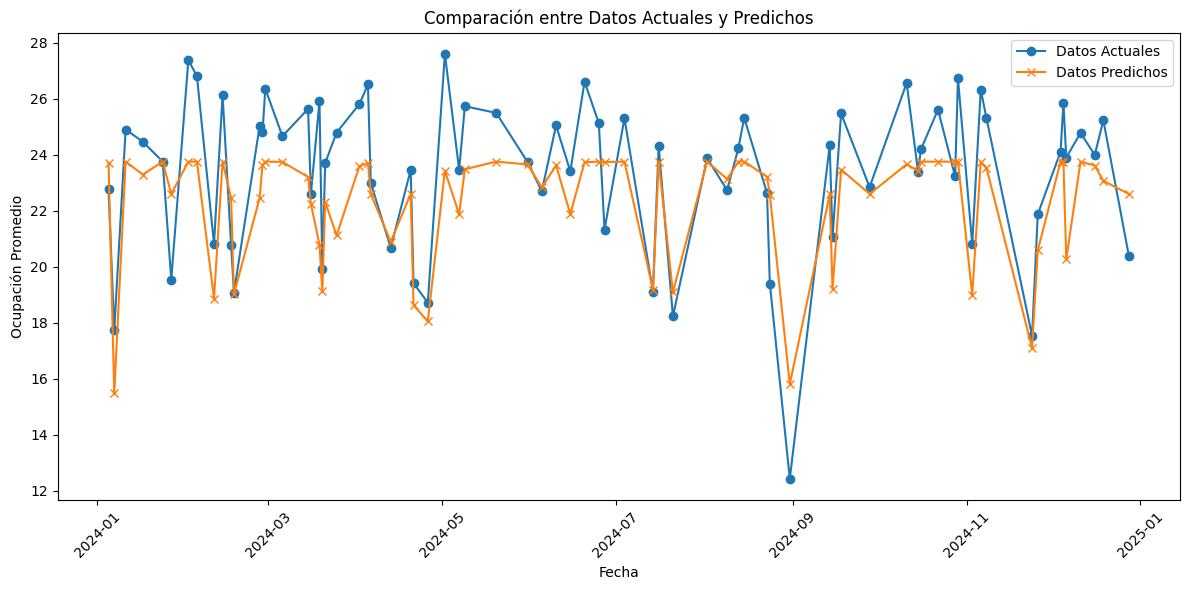

In [61]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model_129.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': fecha_test,
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###Miramos cuales tiene la menor ocupación

In [62]:
datos_combinados.drop_duplicates(subset=['ocupacion_max_avg']).nsmallest(5, 'ocupacion_max_avg')


,fecha,tipo_dia,linea_codigo,acensos_avg,ocupacion_avg,ocupacion_max_avg_avg,ocupacion_max_avg,instant_precipitation_avg,ac_15_avg,ac_1440_avg
20486,2024-06-09,TIPO DOMINGO,484,0.000000,0.000000,-1.000000,-1.000000,0.000923,0.002768,0.159542
33222,2024-09-14,TIPO SABADO,484,1.000000,0.000000,-0.333333,-0.333333,0.000126,0.000378,0.016883
44882,2024-12-11,HABIL,503,0.071429,0.032468,-0.214286,-0.214286,0.000000,0.000000,0.000000
38884,2024-10-27,TIPO DOMINGO,503,0.588235,0.083957,-0.088235,-0.088235,0.000000,0.000000,0.000099
26,2024-01-01,FERIADO NO LABORABLE,57,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


####Linea 484 que es la de menor ocupación

In [63]:
# Se filtra una línea específica
linea_especifica = 484
datos_filtrados_linea484 = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica]

In [64]:
# Definir las columnas necesarias
datos_filtrados_linea484 = datos_filtrados_linea484[['fecha', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg',  'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_linea484.set_index('fecha', inplace=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,137 (12.25 KB)

 Trainable params: 3,137 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 13.9172 - mae: 3.0619 - val_loss: 17.1907 - val_mae: 3.2661
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 13.4044 - mae: 2.9496 - val_loss: 13.6117 - val_mae: 2.8297
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.9061 - mae: 2.5444 - val_loss: 10.5673 - val_mae: 2.4127
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.4238 - mae: 2.1507 - val_loss: 8.0965 - val_mae: 2.0284
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.5334 - mae: 1.9897 - val_loss: 6.4103 - val_mae: 1.7225
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.6190 - mae: 1.6185 - val_loss: 5.6525 - val_mae: 1.6232
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.0042 - mae: 1.5148 - val_loss: 5.6216 - val_mae: 1.6312
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.4689 - mae: 1.6075 - val_loss: 5.7321 - val_mae: 1.6730
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.0216 - 

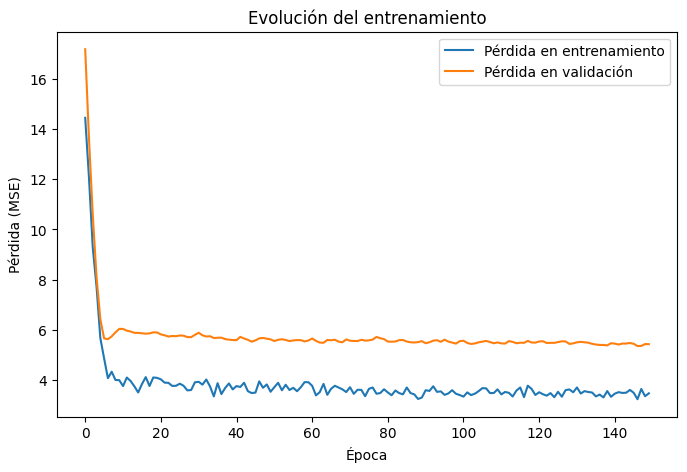

In [65]:
# Reiniciar el índice para tener la columna 'fecha' como variable normal
df_linea484 = datos_filtrados_linea484.reset_index()

# Seleccionar variables predictoras y variable objetivo
# Objetivo: predecir 'ocupacion_avg'
# Características: variables numéricas de precipitaciones y la variable categórica 'tipo_dia'

X = df_linea484[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df_linea484['ocupacion_avg']
fechas = df_linea484['fecha']  # Guardamos la fecha para poder graficar posteriormente

# Codificar la variable categórica 'tipo_dia' utilizando OneHotEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tipo_dia'])
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y test, incluyendo la variable 'fecha'
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y, fechas, test_size=0.2, random_state=42
)

# Normalización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo MLP usando una capa de entrada explícita
model_484 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model_484.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Mostrar el resumen del modelo
model_484.summary()

history = model_484.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo en el conjunto de test
loss, mae = model_484.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


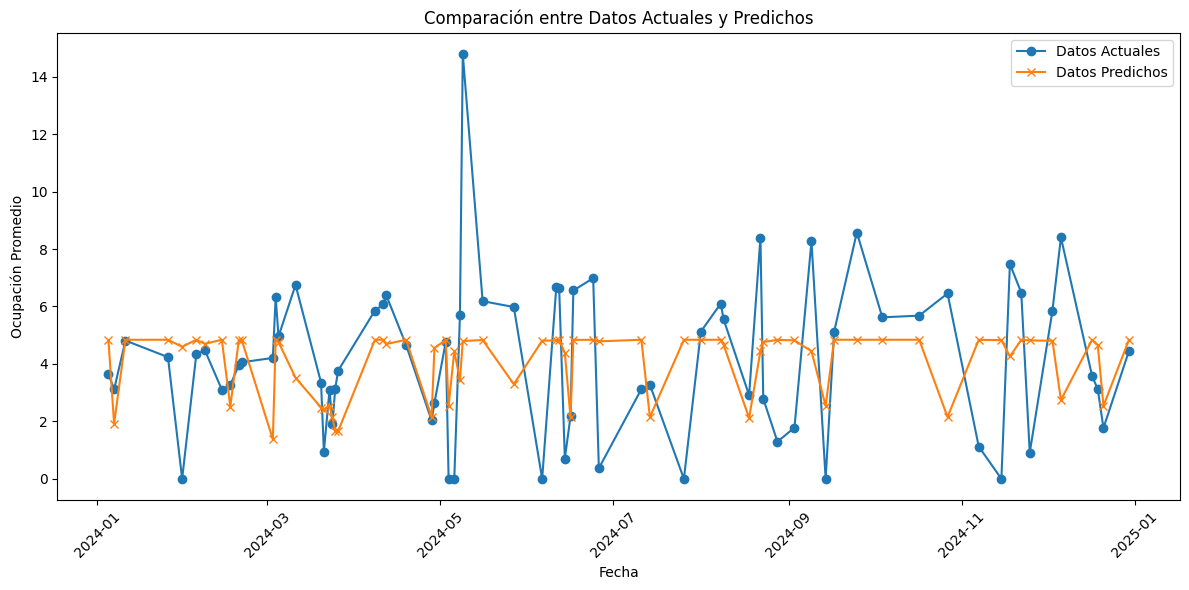

In [66]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model_484.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': fecha_test,
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Selecionamos una linea aleatoria

####Linea 23

In [68]:
# Se filtra una línea específica
linea_especifica = 23
datos_filtrados_linea23 = datos_combinados[datos_combinados['linea_codigo'] == linea_especifica]

In [69]:
# Definir las columnas necesarias
datos_filtrados_linea23 = datos_filtrados_linea23[['fecha', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg',  'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_linea23.set_index('fecha', inplace=True)

In [70]:
#Parametros
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split=0.2

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 374.5717 - mae: 19.1972 - val_loss: 368.3448 - val_mae: 18.9661
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 358.5855 - mae: 18.7432 - val_loss: 359.3716 - val_mae: 18.7043
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 357.1568 - mae: 18.7198 - val_loss: 349.0062 - val_mae: 18.3961
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 342.6939 - mae: 18.3119 - val_loss: 335.9796 - val_mae: 18.0021
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 321.1297 - mae: 17.6436 - val_loss: 318.3652 - val_mae: 17.4770
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 301.5822 - mae: 17.0084 - val_loss: 295.0352 - val_mae: 16.8087
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 275.0288 - mae: 16.1096 - val_loss: 264.6071 - val_mae: 15.8734
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 242.1732 - mae: 15.0418 - val_loss: 226.2410 - val_mae: 14.5763
Epoch 9/150
8/8 ━━━━━━━━

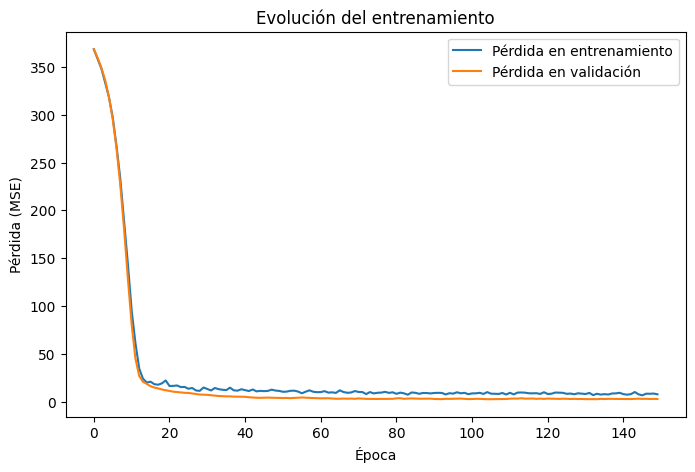

In [71]:
# Reiniciar el índice para tener la columna 'fecha' como variable normal
df_linea23 = datos_filtrados_linea23.reset_index()

# Seleccionar variables predictoras y variable objetivo
# Objetivo: predecir 'ocupacion_avg'
# Características: variables numéricas de precipitaciones y la variable categórica 'tipo_dia'

X = df_linea23[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df_linea23['ocupacion_avg']
fechas = df_linea23['fecha']  # Guardamos la fecha para poder graficar posteriormente

# Codificar la variable categórica 'tipo_dia' utilizando OneHotEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tipo_dia'])
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y test, incluyendo la variable 'fecha'
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y, fechas, test_size=0.2, random_state=42
)

# Normalización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo MLP usando una capa de entrada explícita
model_23 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model_23.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Mostrar el resumen del modelo
model_23.summary()

history = model_23.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo en el conjunto de test
loss, mae = model_23.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


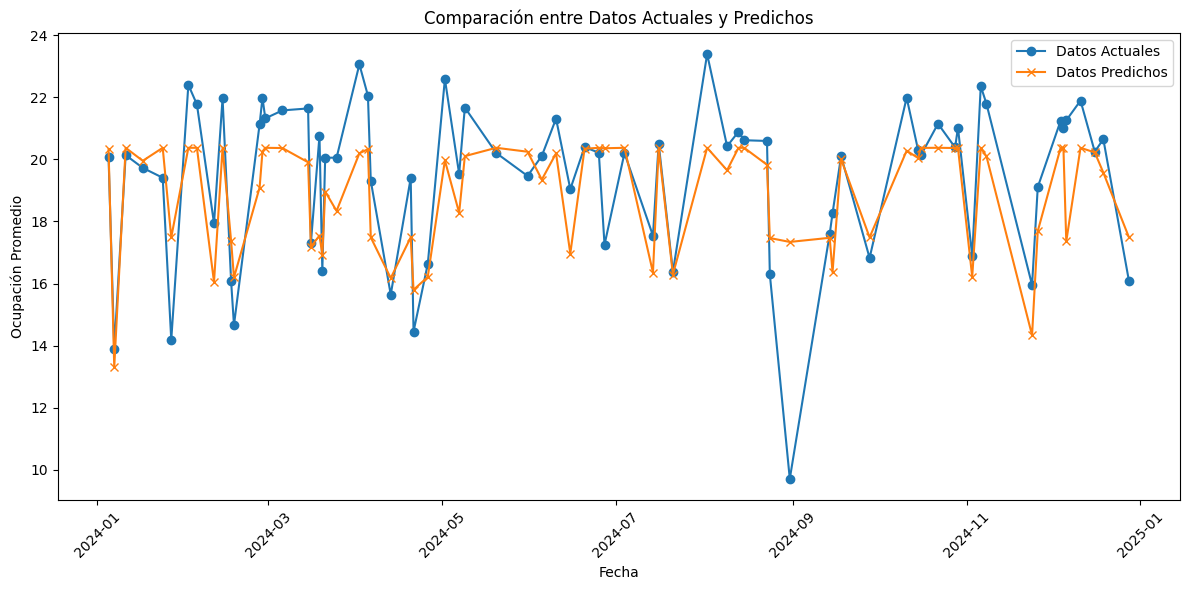

In [72]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model_23.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': fecha_test,
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Hicimos el estudio para 5 líneas distintas que fueron: 447 (aleatoria), 10(mayor ocupación), 129 (mayor ocupación), 484 (menor ocupación) y 23 (aleatoria)

###Modelo entrenado para las 5 lineas a la vez

In [73]:
# Se filtran las líneas específicas
lineas_especificas = [447, 10, 129, 484, 23]
datos_filtrados_todas_lineas = datos_combinados[datos_combinados['linea_codigo'].isin(lineas_especificas)]

In [74]:
# Definir las columnas necesarias
datos_filtrados_todas_lineas3 = datos_filtrados_todas_lineas[['fecha', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg',  'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_todas_lineas.set_index('fecha', inplace=True)

In [75]:
#Parametros
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split=0.2

In [ ]:
# Reiniciar el índice para tener la columna 'fecha' como variable normal
df_linea_todas = datos_filtrados_todas_lineas.reset_index()

# Seleccionar variables predictoras y variable objetivo
# Objetivo: predecir 'ocupacion_avg'
# Características: variables numéricas de precipitaciones y la variable categórica 'tipo_dia'

X = df_linea_todas[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df_linea_todas['ocupacion_avg']
fechas = df_linea_todas['fecha']  # Guardamos la fecha para poder graficar posteriormente

# Codificar la variable categórica 'tipo_dia' utilizando OneHotEncoder.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tipo_dia'])
    ],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y test, incluyendo la variable 'fecha'
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y, fechas, test_size=0.2, random_state=42
)

# Normalización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir el modelo MLP usando una capa de entrada explícita
model_todas = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model_todas.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Mostrar el resumen del modelo
model_todas.summary()

history = model_todas.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo en el conjunto de test
loss, mae = model_todas.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 344.6891 - mae: 17.0818 - val_loss: 292.2682 - val_mae: 15.4597
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 258.1194 - mae: 14.4531 - val_loss: 126.7429 - val_mae: 10.0819
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 98.4416 - mae: 8.8448 - val_loss: 61.4919 - val_mae: 5.9316
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 63.1504 - mae: 6.2622 - val_loss: 58.7564 - val_mae: 6.3312
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 58.9082 - mae: 6.1674 - val_loss: 56.7123 - val_mae: 6.0091
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 62.4591 - mae: 6.3544 - val_loss: 55.4101 - val_mae: 5.8336
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 63.6106 - mae: 6.3069 - val_loss: 54.6934 - val_mae: 5.7478
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 58.4941 - mae: 6.1341 - val_loss: 54.6869 - val_mae: 5.9429
Epoch 9/150
37/37 ━━━━━━━━━━━━━━━━━━━━

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


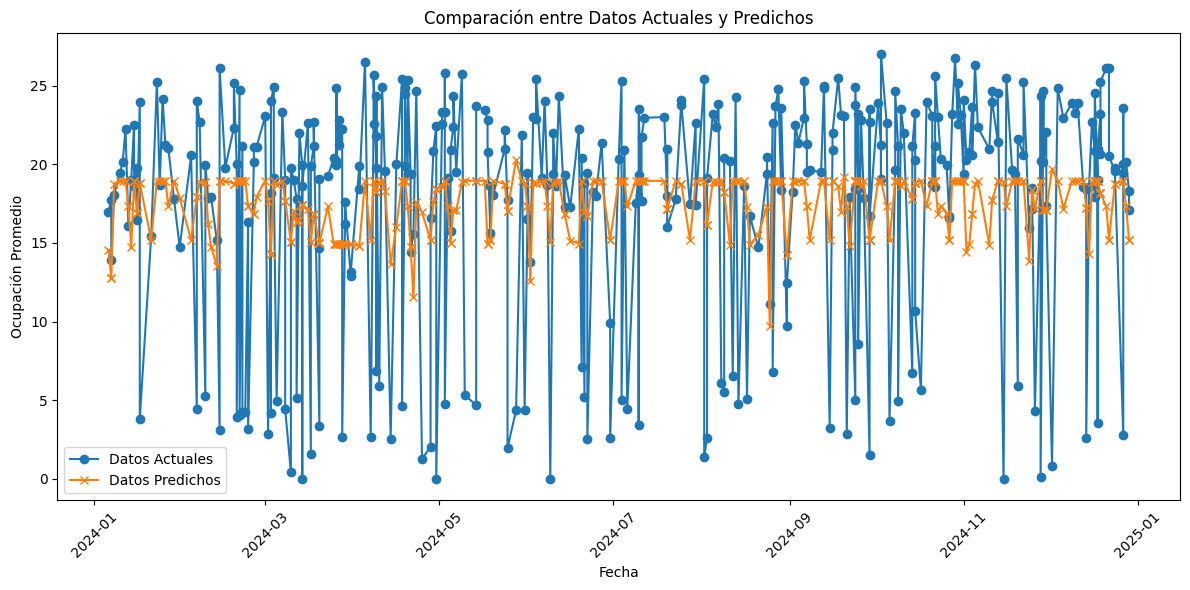

In [77]:
# Graficamos la comparación de los datos actuales y predichos

predicciones = model_todas.predict(X_test).flatten()

resultados = pd.DataFrame({
    'fecha': fecha_test,
    'actual': y_test,
    'prediccion': predicciones
})
# Ordenar por fecha para graficar en orden cronológico
resultados.sort_values('fecha', inplace=True)

# Graficar los datos actuales y los datos predichos
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Entrenando modelo para la línea 447...

Línea 447 - Error Absoluto Medio (MAE) en test: 1.1529314517974854


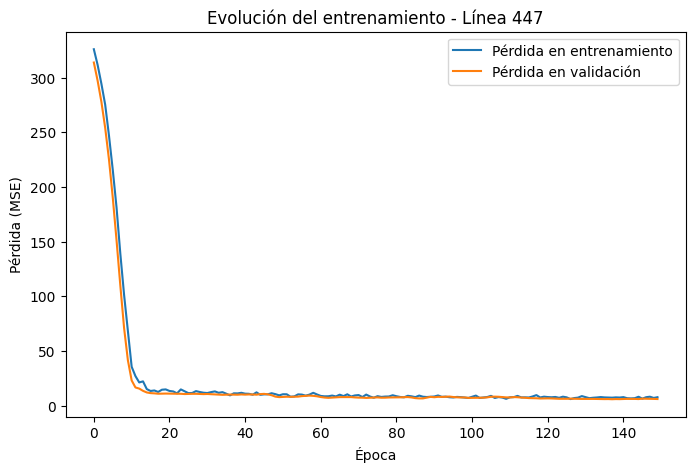

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


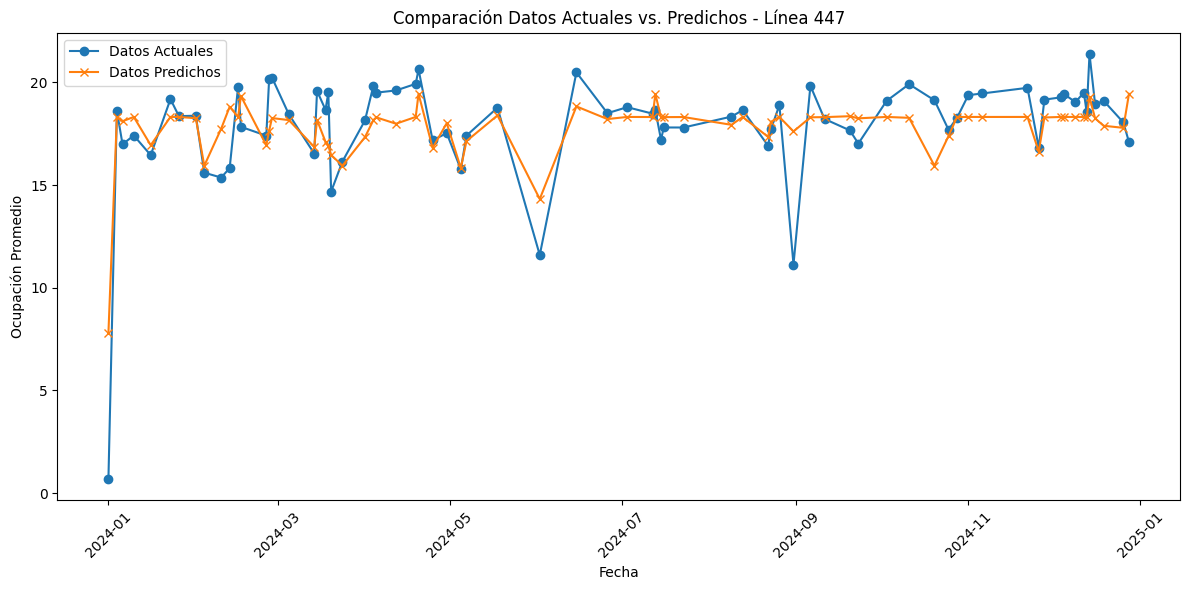


Entrenando modelo para la línea 10...

Línea 10 - Error Absoluto Medio (MAE) en test: 1.3496639728546143


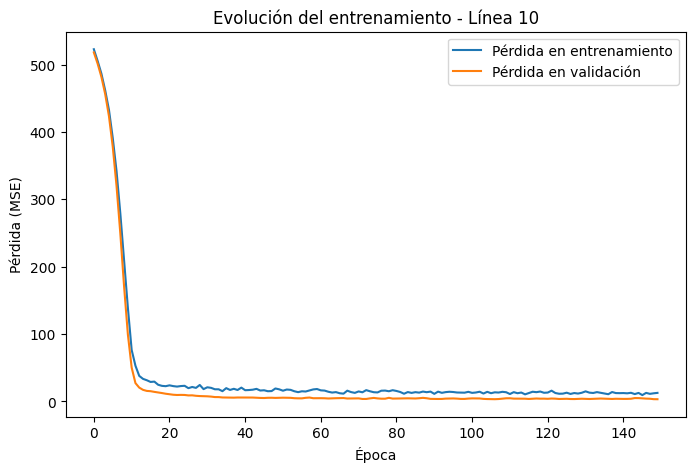

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


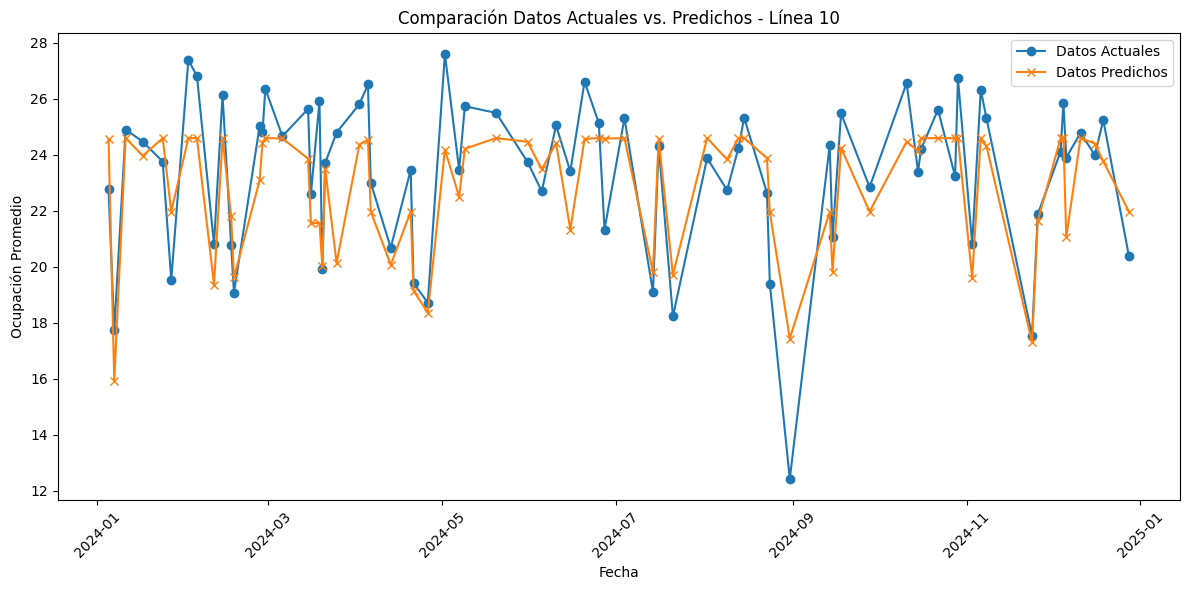


Entrenando modelo para la línea 129...

Línea 129 - Error Absoluto Medio (MAE) en test: 1.4326425790786743


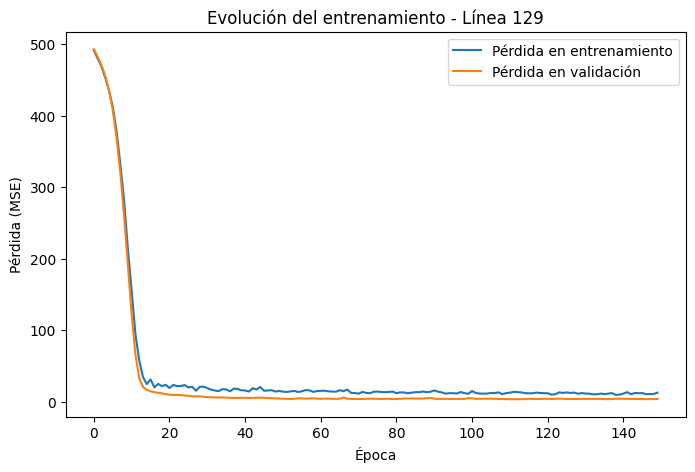

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


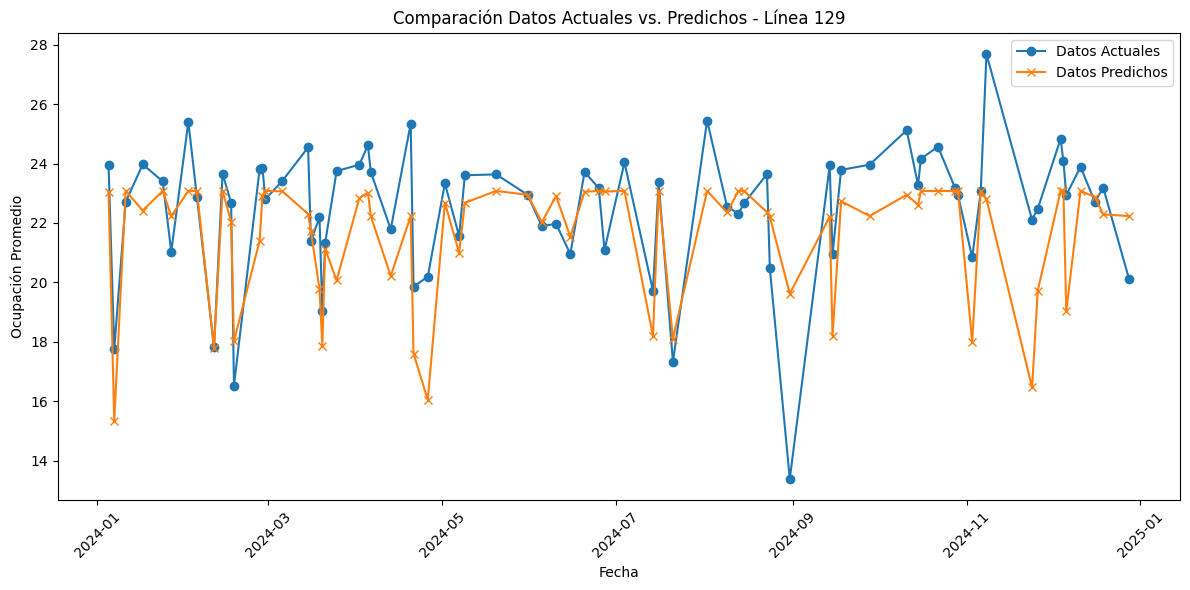


Entrenando modelo para la línea 484...

Línea 484 - Error Absoluto Medio (MAE) en test: 2.018768072128296


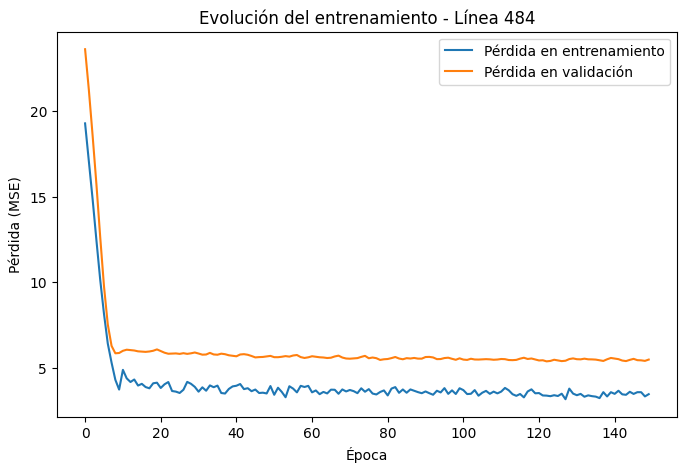

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


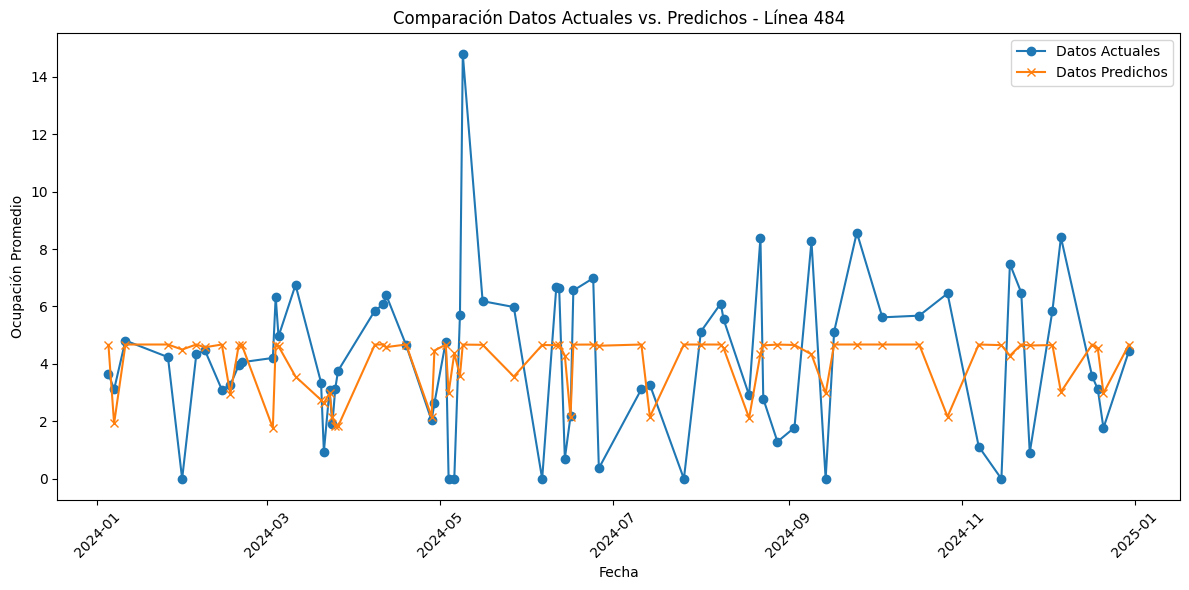


Entrenando modelo para la línea 23...

Línea 23 - Error Absoluto Medio (MAE) en test: 1.2802298069000244


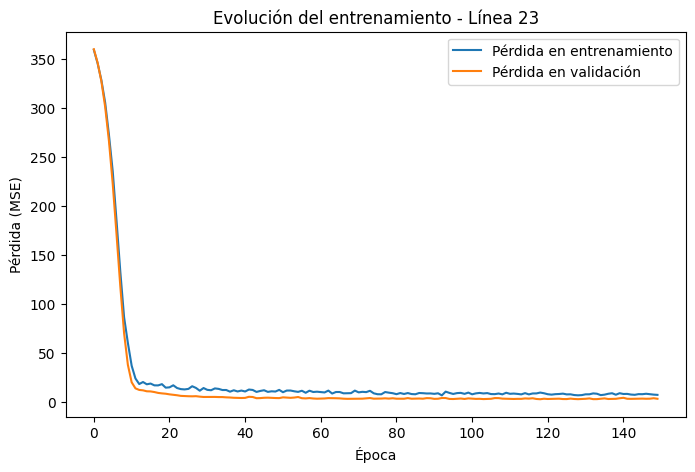

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


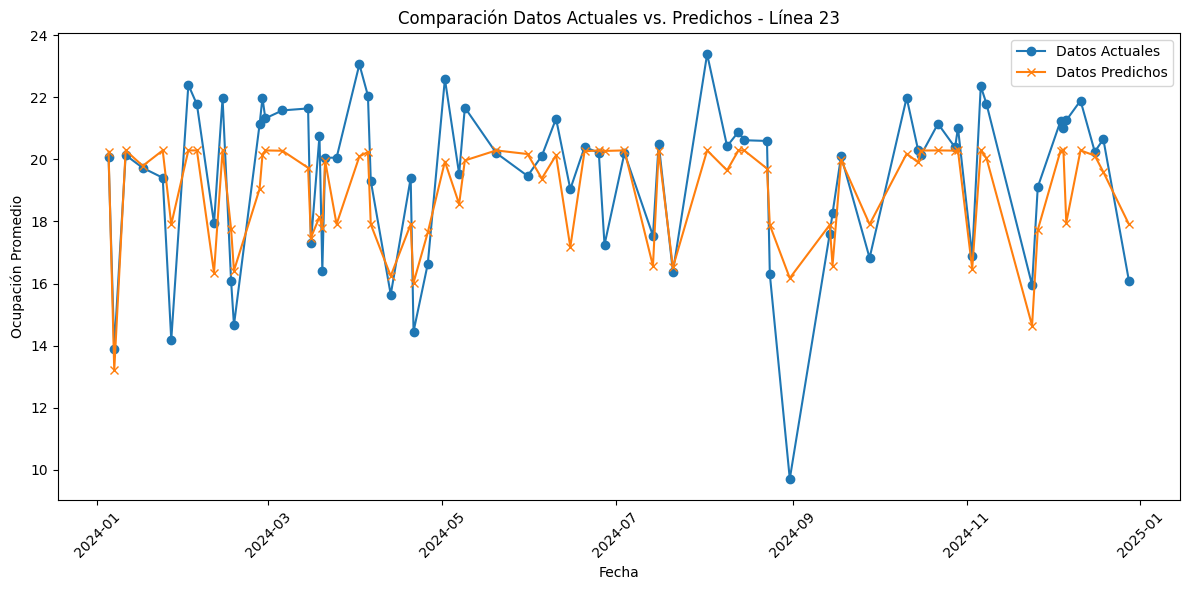

In [79]:
# Se filtran las líneas específicas
lineas_especificas = [447, 10, 129, 484, 23]
datos_filtrados_todas_lineas = datos_combinados[datos_combinados['linea_codigo'].isin(lineas_especificas)]

# Definir las columnas necesarias
datos_filtrados_todas_lineas = datos_filtrados_todas_lineas[['fecha', 'tipo_dia', 'linea_codigo', 'ocupacion_avg', 'instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_todas_lineas.set_index('fecha', inplace=True)

# Parámetros del modelo
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split = 0.2

# Iterar sobre cada línea y entrenar un modelo separado
for linea in lineas_especificas:
    print(f"\nEntrenando modelo para la línea {linea}...\n")

    df_linea = datos_filtrados_todas_lineas[datos_filtrados_todas_lineas['linea_codigo'] == linea].reset_index()

    # Selección de variables predictoras y objetivo
    X = df_linea[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
    y = df_linea['ocupacion_avg']
    fechas = df_linea['fecha']

    # Codificación de la variable categórica
    preprocessor = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(), ['tipo_dia'])],
        remainder='passthrough'
    )

    X_preprocessed = preprocessor.fit_transform(X)

    # División de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
        X_preprocessed, y, fechas, test_size=0.2, random_state=42
    )

    # Normalización de datos
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Definir el modelo MLP
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

    # Entrenar el modelo
    history = model.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=0)

    # Evaluar el modelo
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f'Línea {linea} - Error Absoluto Medio (MAE) en test: {mae}')

    # Graficar la evolución del entrenamiento
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida en validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.legend()
    plt.title(f'Evolución del entrenamiento - Línea {linea}')
    plt.show()

    # Predicción y comparación con los datos reales
    predicciones = model.predict(X_test).flatten()

    resultados = pd.DataFrame({'fecha': fecha_test, 'actual': y_test, 'prediccion': predicciones})
    resultados.sort_values('fecha', inplace=True)

    # Graficar resultados por línea
    plt.figure(figsize=(12, 6))
    plt.plot(resultados['fecha'], resultados['actual'], marker='o', label='Datos Actuales')
    plt.plot(resultados['fecha'], resultados['prediccion'], marker='x', label='Datos Predichos')
    plt.xlabel('Fecha')
    plt.ylabel('Ocupación Promedio')
    plt.title(f'Comparación Datos Actuales vs. Predichos - Línea {linea}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [81]:
print(datos_combinados.columns)

Index(['fecha', 'tipo_dia', 'linea_codigo', 'acensos_avg', 'ocupacion_avg',
       'ocupacion_max_avg_avg', 'ocupacion_max_avg',
       'instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg'],
      dtype='object')


In [ ]:
# Se filtran las líneas específicas
lineas_especificas = [447, 10, 129, 484, 23]
datos_filtrados_todas_lineas = datos_combinados[datos_combinados['linea_codigo'].isin(lineas_especificas)]

# Definir las columnas necesarias
datos_filtrados_todas_lineas = datos_filtrados_todas_lineas[['fecha', 'tipo_dia', 'linea_codigo', 'ocupacion_avg',
                                                             'instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg']]
datos_filtrados_todas_lineas.set_index('fecha', inplace=True)

# Parámetros del modelo
p_learning_rate = 0.001
p_epochs = 150
p_batch_size = 32
p_validation_split = 0.2

# Reiniciar el índice
df_lineas = datos_filtrados_todas_lineas.reset_index()

# Selección de variables predictoras y objetivo
X = df_lineas[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y = df_lineas[['ocupacion_avg']]
fechas = df_lineas['fecha']

# Codificar la variable categórica 'tipo_dia'
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['tipo_dia'])],
    remainder='passthrough'
)

X_preprocessed = preprocessor.fit_transform(X)

# Codificar la línea como One-Hot Encoding para usarla como salida
encoder_lineas = OneHotEncoder(sparse_output=False)
y_encoded = encoder_lineas.fit_transform(df_lineas[['linea_codigo']])

# Dividir datos en entrenamiento y test
X_train, X_test, y_train, y_test, fecha_train, fecha_test = train_test_split(
    X_preprocessed, y_encoded, fechas, test_size=0.2, random_state=42
)

# Normalizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Definir el modelo MLP**
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(len(lineas_especificas), activation='linear')  # La ultima capa le se ajusta a la cantidad de lineas
])

model.compile(optimizer=Adam(learning_rate=p_learning_rate), loss='mean_squared_error', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=p_epochs, batch_size=p_batch_size, validation_split=p_validation_split, verbose=1)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE) en test: {mae}')

# Graficar la evolución del entrenamiento
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.title('Evolución del entrenamiento')
plt.show()

# **Hacer predicciones**
predicciones = model.predict(X_test)

# Convertir las predicciones al formato original (ocupación promedio por línea)
y_test_decoded = np.argmax(y_test, axis=1)  # Obtener la línea real
y_pred_decoded = np.argmax(predicciones, axis=1)  # Línea predicha

# **Crear un DataFrame con los resultados**
resultados = pd.DataFrame({
    'fecha': fecha_test,
    'linea_real': encoder_lineas.inverse_transform(y_test),
    'linea_predicha': encoder_lineas.inverse_transform(y_pred_decoded.reshape(-1, 1)).flatten(),
})

# Ordenar por fecha
resultados.sort_values('fecha', inplace=True)

# **Graficar los resultados por línea**
plt.figure(figsize=(12, 6))
for linea in lineas_especificas:
    subset = resultados[resultados['linea_real'] == linea]
    plt.plot(subset['fecha'], subset['linea_real'], marker='o', label=f'Línea {linea}')

plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación entre Datos Actuales y Predichos')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Conclución
Cuando entrenamos el modelo de MLP por líneas se ajustó bastante bien y dio buenos resultados, pero cuando entrenamos por más de una línea vemos que se pierden muchos picos en la predicción. Una prueba para mejorar esto es ajustar la franja horaria, o sea en vez de uno por día que sea cada 1 hora o menos. Seguiremos con esta pruebas a continuación

In [ ]:
##Prueba de modelo qeu devuelva un vector que tenga la ocupacion y la linea y capas l afranja horaria

# Filtrar las líneas específicas
lineas_especificas = [447, 10, 129, 484, 23]  # Puedes poner más líneas aquí
datos_filtrados = datos_combinados[datos_combinados['linea_codigo'].isin(lineas_especificas)]

# Seleccionar columnas necesarias
datos_filtrados = datos_filtrados[['fecha', 'linea_codigo', 'tipo_dia', 'ocupacion_avg', 'instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg']]
datos_filtrados.set_index('fecha', inplace=True)

# Codificar la línea como One-Hot
encoder_lineas = OneHotEncoder(sparse_output=False)
y_lineas_codificadas = encoder_lineas.fit_transform(datos_filtrados[['linea_codigo']])

# Codificar 'tipo_dia' como variable categórica
preprocessor = ColumnTransformer([
    ('tipo_dia', OneHotEncoder(), ['tipo_dia'])
], remainder='passthrough')

X = datos_filtrados[['instant_precipitation_avg', 'ac_15_avg', 'ac_1440_avg', 'tipo_dia']]
y_ocupacion = datos_filtrados['ocupacion_avg'].values.reshape(-1, 1)  # Asegurar que sea 2D

# Aplicar transformaciones
X_preprocessed = preprocessor.fit_transform(X)

# Concatenar las salidas en un solo vector
y_total = np.hstack([y_lineas_codificadas, y_ocupacion])

# Dividir en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_total, test_size=0.2, random_state=42)

# Normalizar datos numéricos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir la arquitectura del modelo con salida vectorial
input_layer = Input(shape=(X_train.shape[1],))

hidden = Dense(64, activation='relu')(input_layer)
hidden = Dropout(0.2)(hidden)
hidden = Dense(32, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
hidden = Dense(16, activation='relu')(hidden)

# Salida: vector con [línea_codificada, ocupación]
output = Dense(y_train.shape[1], activation='linear', name='salida_vector')(hidden)

# Definir modelo con salida única
model = Model(inputs=input_layer, outputs=output)

# Función de pérdida combinada
def custom_loss(y_true, y_pred):
    # Separar línea y ocupación
    y_true_linea = y_true[:, :-1]  # Todas las columnas menos la última
    y_pred_linea = y_pred[:, :-1]

    y_true_ocupacion = y_true[:, -1]  # Última columna
    y_pred_ocupacion = y_pred[:, -1]

    # Pérdida de clasificación (Categorical Crossentropy)
    loss_linea = CategoricalCrossentropy()(y_true_linea, y_pred_linea)

    # Pérdida de regresión (MSE)
    loss_ocupacion = MeanSquaredError()(y_true_ocupacion, y_pred_ocupacion)

    # Peso ajustable entre ambas pérdidas
    return loss_linea + 0.5 * loss_ocupacion

# Compilar modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss, metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Error Absoluto Medio (MAE): {mae:.4f}')

# Predicciones
y_pred = model.predict(X_test)

# Separar predicciones
y_pred_linea = y_pred[:, :-1]  # Todas las columnas menos la última
y_pred_ocupacion = y_pred[:, -1]  # Última columna

# Decodificar la línea predicha
lineas_predichas = encoder_lineas.inverse_transform(y_pred_linea)

# Guardar resultados en un DataFrame
resultados = pd.DataFrame({
    'fecha': datos_filtrados.index[-len(y_test):],  # Fechas de test
    'linea_real': encoder_lineas.inverse_transform(y_test[:, :-1]),
    'linea_predicha': lineas_predichas.flatten(),
    'ocupacion_real': y_test[:, -1],
    'ocupacion_predicha': y_pred_ocupacion
})

# Ordenar por fecha
resultados.sort_values('fecha', inplace=True)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(resultados['fecha'], resultados['ocupacion_real'], marker='o', label='Ocupación Real')
plt.plot(resultados['fecha'], resultados['ocupacion_predicha'], marker='x', label='Ocupación Predicha')
plt.xlabel('Fecha')
plt.ylabel('Ocupación Promedio')
plt.title('Comparación de Ocupación Real vs. Predicha')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
